In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns

style.use("fivethirtyeight")
import gc
import math
import os
import sys

import h5py
import pytorch_lightning as pl
import torch
from pytorch_lightning import seed_everything
from pytorch_lightning.metrics.functional import accuracy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm.auto import tqdm

pd.set_option("display.max_rows", 100)

SEED = 69
seed_everything(SEED)

69

# Prepare Dataset

In [2]:
%%time

# This code is needed for dataset
train = pd.read_pickle("riiid_train.pkl.gzip")
questions_df = pd.read_csv("data/questions.csv")
lectures_df = pd.read_csv("data/lectures.csv")

folder_path = "data"
print("Loading lectures arrays")
lectures_ids = np.load(f"{folder_path}/lectures_ids.npy")
lectures_parts = np.load(f"{folder_path}/lectures_parts.npy")
lectures_types = np.load(f"{folder_path}/lectures_types.npy")
lectures_tags = lectures_df.tag.values

print("Loading questions arrays")
questions_parts = np.load(f"{folder_path}/questions_parts.npy")
questions_lectures_parts = np.concatenate([questions_parts, lectures_parts])


# process tags
def split_tags(t):
    try:
        return [int(i) for i in t.split(" ")]
    except AttributeError:
        return list()


# Get tags to be 2D array of shape (Q, T), where Q is question_idx, and T is the max number of tag possible (6)
questions_df["tags"] = questions_df.tags.apply(split_tags)
questions_tags = pd.DataFrame(questions_df["tags"].tolist(), index=questions_df.index)

# map lecture id to new id

lectures_mapping = dict(
    zip(lectures_df.lecture_id.values, (lectures_df.index + 13523).values)
)
lectures_df.lecture_id = lectures_df.index + 13523
lectures_tags = pd.DataFrame(
    lectures_df.tag.values, index=lectures_df.lecture_id.values
)

questions_lectures_tags = pd.concat([questions_tags, lectures_tags])
# pad with max tag + 1
questions_lectures_tags = (
    questions_lectures_tags.fillna(questions_lectures_tags.max().max() + 1)
    .astype(np.int)
    .values
)

Loading lectures arrays
Loading questions arrays
CPU times: user 27.7 ms, sys: 965 ms, total: 992 ms
Wall time: 991 ms


#### Preprocess Dataframe

In [3]:
def preprocess_df(df):
    """
    Converts the lecture ids to proper content_ids
    Adds the answered_correctly column if not exists
    """
    df.content_type_id = df.content_type_id.astype(bool)

    # prior information
    df.prior_question_elapsed_time = (
        df.prior_question_elapsed_time.fillna(0).clip(upper=300000) / 300000
    )  # normalizes to 0-1

    # map lecture ids to new content_ids
    df.loc[df.content_type_id, "content_id"] = df[df.content_type_id].content_id.map(
        lectures_mapping
    )
    # if not answered correctly then add column with
    # y = 3 (padding) for all questions and y = 4 for lectures
    if "answered_correctly" not in df.columns:
        df["answered_correctly"] = df.content_type_id.map({False: 3, True: 4})

    return df

#### Time Features

In [4]:
eps = 0.0000001
def get_time_elapsed_from_timestamp(arr):
    arr_seconds = np.diff(arr, prepend=0) / 1000
    return (np.log(arr_seconds + eps).astype(np.float32)-3.5) / 20

# ## Show effects of transformation 
# times = train.groupby("user_id").timestamp.apply(get_time_elapsed_from_timestamp)
# times = np.concatenate(times.tolist())
# sns.boxplot(x=times)

### Split Dataset

## Generate Hdf5

Only run this once.

In [7]:
%%time
train = preprocess_df(train) #convert lecture ids to be sequentially following the question_ids

CPU times: user 1.01 s, sys: 302 ms, total: 1.32 s
Wall time: 1.05 s


In [11]:
train.columns

Index(['row_id', 'timestamp', 'user_id', 'content_id', 'content_type_id',
       'task_container_id', 'user_answer', 'answered_correctly',
       'prior_question_elapsed_time', 'prior_question_had_explanation'],
      dtype='object')

In [10]:
train.answered_correctly.replace(-1, 4, inplace=True) # set lecture to token 4 for answered correctly

In [12]:
# ignore lectures for now
hf = h5py.File("feats.h5", "w")

for user_id, data in tqdm(train.groupby("user_id")):
    processed_feats = data[
        [
            "content_id",
            "answered_correctly",
            "timestamp",
            "prior_question_elapsed_time",
        ]
    ].values

    hf.create_dataset(f"{user_id}/content_ids", data=processed_feats[:, 0], maxshape=(None,))
    hf.create_dataset(f"{user_id}/answered_correctly", data=processed_feats[:, 1], maxshape=(None,))
    hf.create_dataset(f"{user_id}/timestamps", data=processed_feats[:, 2], maxshape=(None,))
    hf.create_dataset(f"{user_id}/prior_question_elapsed_time", data=processed_feats[:, 3], maxshape=(None,))

hf.close()

## Pytorch Stuff

### Data

Here we define the pytorch Dataset object and a custom collate function. 

In [5]:
class RIIDDataset(Dataset):
    """RIID dataset."""

    def __init__(
        self,
        user_mapping,
        user_history,
        hdf5_file="feats.h5",
        window_size=100,
        use_cache=False,
    ):
        """
        Args:
            user_mapping (np.array): array of user_ids per row
            user_history (np.array): array of length of history up till this row
            hdf5_file (string): location of hf5 feats file
            window_size (int): size of window to lookback to max
            use_cache (opt, bool): whether to cache reads
        """
        # np array where index maps to a user id
        self.user_mapping = user_mapping
        self.user_history = user_history
        self.hdf5_file = f"{hdf5_file}"
        self.max_window_size = window_size
        self.use_cache = use_cache
        self.cache = {}

    def open_hdf5(self):
        # opens the h5py file
        self.f = h5py.File(self.hdf5_file, "r")

    def __len__(self):
        return len(self.user_mapping)

    def load_user_into_cache(self, user_id):
        """
        add a user to self.cache
        """

        self.cache[user_id] = {
            "content_ids": np.array(self.f[f"{user_id}/content_ids"], dtype=np.int64),
            "answered_correctly": np.array(
                self.f[f"{user_id}/answered_correctly"], dtype=np.int64
            ),
            "timestamps": np.array(self.f[f"{user_id}/timestamps"], dtype=np.float32),
            "prior_question_elapsed_time": np.array(
                self.f[f"{user_id}/prior_question_elapsed_time"], dtype=np.float32
            ),
        }
    def preload_all(self):
        if not hasattr(self, "f"):
            self.open_hdf5()
        for u in tqdm(np.unique(dataset.user_mapping)):
            self.load_user_into_cache(u)


    def __getitem__(self, idx):

        # open the hdf5 file in the iterator to allow multiple workers
        # https://github.com/pytorch/pytorch/issues/11929
        if not hasattr(self, "f"):
            self.open_hdf5()

        if torch.is_tensor(idx):
            idx = idx.tolist()

        user_id = self.user_mapping[idx]
        length = self.user_history[idx]
        # length = self.f[f"{user_id}/answered_correctly"].len()

        window_size = min(self.max_window_size, length)

        # index for loading larger than window size
        start_index = 0
        if length > window_size:
            # randomly select window size subset instead of trying to cram in everything
            start_index = length - window_size

        if not self.use_cache:
            content_ids = np.zeros(window_size, dtype=np.int64).copy()
            answered_correctly = np.zeros(window_size, dtype=np.int64).copy()
            timestamps = np.zeros(window_size, dtype=np.float32).copy()
            prior_q_times = np.zeros(window_size, dtype=np.float32).copy()

            self.f[f"{user_id}/content_ids"].read_direct(
                content_ids,
                source_sel=np.s_[start_index : start_index + window_size],
                dest_sel=np.s_[0:window_size],
            )
            self.f[f"{user_id}/answered_correctly"].read_direct(
                answered_correctly,
                source_sel=np.s_[start_index : start_index + window_size],
                dest_sel=np.s_[0:window_size],
            )
            self.f[f"{user_id}/timestamps"].read_direct(
                timestamps,
                source_sel=np.s_[start_index : start_index + window_size],
                dest_sel=np.s_[0:window_size],
            )
            self.f[f"{user_id}/prior_question_elapsed_time"].read_direct(
                prior_q_times,
                source_sel=np.s_[start_index : start_index + window_size],
                dest_sel=np.s_[0:window_size],
            )
        else:
            if user_id not in self.cache:
                self.load_user_into_cache(user_id)

            content_ids = self.cache[user_id]["content_ids"][
                start_index : start_index + window_size
            ].copy()
            answered_correctly = self.cache[user_id]["answered_correctly"][
                start_index : start_index + window_size
            ].copy()
            timestamps = self.cache[user_id]["timestamps"][
                start_index : start_index + window_size
            ].copy()
            prior_q_times = self.cache[user_id]["prior_question_elapsed_time"][
                start_index : start_index + window_size
            ].copy()

        # convert timestamps to time elapsed
        time_elapsed_timestamps = get_time_elapsed_from_timestamp(timestamps)

        # get question tags
        tags = questions_lectures_tags[content_ids, :]

        # get question parts
        parts = questions_lectures_parts[content_ids]

        # shift by one the answered_correctly sequence
        answers = np.roll(answered_correctly, 1)

        # set start token if start_index is actually first element
        if start_index == 0:
            answers[0] = 2
        # else replace first element of sequence with actual previous element
        else:
            self.f[f"{user_id}/answered_correctly"].read_direct(
                answers, source_sel=np.s_[start_index - 1], dest_sel=np.s_[0],
            )

        return {
            "parts": torch.from_numpy(parts).long(),
            "tags": torch.from_numpy(tags).long(),
            "content_ids": torch.from_numpy(content_ids),
            "answered_correctly": torch.from_numpy(answered_correctly),
            "answers": torch.from_numpy(answers),
            "timestamps": torch.from_numpy(time_elapsed_timestamps),
            "prior_q_times": torch.from_numpy(prior_q_times),
            "length": window_size,
        }

In [6]:
from torch.nn.utils.rnn import pad_sequence


# The collate function is used to merge individual data samples into a batch
# It handles the padding aspect
def collate_fn(batch):
    # collate lenghts into 1D tensor
    items = {"length": torch.tensor([batch_item["length"] for batch_item in batch])}

    # find shape that the batch will have
    max_length = items["length"].max()
    num_items = len(batch)

    # padding list
    for (key, padding) in [
        ("parts", 0),
        ("content_ids", 13942),
        ("answered_correctly", 3),
        ("answers", 3),
        ("timestamps", 0.0),  # note timestamps isnt an embedding
        ("tags", 188),
        ("prior_q_times", 0),
    ]:
        items[key] = pad_sequence(
            [batch_item[key] for batch_item in batch],
            batch_first=False,
            padding_value=padding,
        )

    # mask to weight loss by (S, N)
    items["loss_mask"] = (
        (
            torch.arange(max_length).expand(num_items, max_length)
            < items["length"].unsqueeze(1)
        )
        .transpose(1, 0)
        .float()
    )
    items["loss_mask"] *= items["answered_correctly"] != 4  # mask the lectures
    items["answered_correctly"] = items["answered_correctly"].float()

    return items

#### Hyperparams

In [7]:
batch_size = 1024
max_window_size = 100

#### Dataset + Dataloaders

In [9]:
%%time
# Create Dataset with all rows
user_mapping = train.user_id.values
user_history = train.groupby("user_id").cumcount().values + 1

dataset = RIIDDataset(
    user_mapping, user_history, hdf5_file="feats.h5", window_size=100, use_cache=True
)
len(dataset)

CPU times: user 2.89 s, sys: 953 ms, total: 3.84 s
Wall time: 3.85 s


101230332

In [16]:
dataset[500]

In [10]:
%%time
## if not using lectures
train = train.reset_index(drop=True)
q_train_indices = train[
    train.row_id.isin(cv_train_ids[~cv_train_ids.content_type_id].row_id.values)
].index.values

q_valid_indices = train[
    train.row_id.isin(cv_valid_ids[~cv_valid_ids.content_type_id].row_id.values)
].index.values

CPU times: user 17.6 s, sys: 3.52 s, total: 21.2 s
Wall time: 21.2 s


In [11]:
# %%time
# if using lectures
# question_ids = train[~train.content_type_id].row_id.values
# q_train_indices = np.intersect1d(question_ids, cv_train_ids)
# q_valid_indices = np.intersect1d(question_ids, cv_valid_ids)

In [11]:
from torch.utils.data import Subset

# Init DataLoader from RIIID Dataset subset
train_loader = torch.utils.data.DataLoader(
    dataset=Subset(dataset, q_train_indices),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),  # if GPU then pin memory for perf
)
val_loader = torch.utils.data.DataLoader(
    dataset=Subset(dataset, q_valid_indices),
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=6,
    pin_memory=torch.cuda.is_available(),
)

In [12]:
# train_idxs, val_idxs = get_train_val_idxs(train)

### Model

In [8]:
from pytorch_lightning.core.decorators import auto_move_data
from pytorch_lightning.metrics.functional.classification import auroc
from torch.nn import TransformerEncoder, TransformerEncoderLayer


def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, sequence_length):
        # returns embeds (sequence_length, 1, d_model)
        return self.pe[:sequence_length, :]


class RIIDDTransformerModel(pl.LightningModule):
    def __init__(
        self,
        learning_rate=0.001,
        n_content_id=13943,  # number of different contents = 13942 + 1 (for padding)
        n_part=8,  # number of different parts = 7 + 1 (for padding)
        n_tags=189,  # number of different tags = 188 + 1 (for padding)
        n_correct=5,  # 0,1 (false, true), 2 (start token), 3 (padding), 4 (lecture)
        emb_dim=64,  # embedding dimension
        dropout=0.1,
        n_heads: int = 1,
        n_encoder_layers: int = 2,
        n_decoder_layers: int = 2,
        dim_feedforward: int = 256,
        activation: str = "relu",
        max_window_size=100,
        use_prior_q_times=False,
        use_prior_q_explanation=False,
    ):
        super(RIIDDTransformerModel, self).__init__()
        self.model_type = "RiiidTransformer"
        self.learning_rate = learning_rate
        self.max_window_size = max_window_size

        self.use_prior_q_times = use_prior_q_times
        self.use_prior_q_explanation = use_prior_q_explanation

        # save params of models to yml
        self.save_hyperparameters()

        #### EXERCISE SEQUENCE
        self.embed_content_id = nn.Embedding(n_content_id, emb_dim, padding_idx=13942)
        self.embed_parts = nn.Embedding(n_part, emb_dim, padding_idx=0)
        self.embed_tags = nn.Embedding(n_tags, emb_dim, padding_idx=188)

        # exercise weights to weight the mean embeded excercise embeddings
        self.exercise_weights = torch.nn.Parameter(torch.tensor([0.35, 0.55, 0.1]))

        ### RESPONSE SEQUENCE (1st time stamp of sequence is useless)
        self.embed_answered_correctly = nn.Embedding(
            n_correct, emb_dim, padding_idx=3
        )  # 2 + 1 for start token + 1 for padding_idn_inputs

        self.embed_timestamps = nn.Linear(1, emb_dim)

        # embed prior q time and q explanation
        self.embed_prior_q_time = nn.Linear(1, emb_dim)
        self.embed_prior_q_explanation = nn.Embedding(2, emb_dim)

        # response weights to weight the mean embeded response embeddings
        w = [0.5, 0.5]
        if use_prior_q_times:
            w.append(0.5)
        if use_prior_q_explanation:
            w.append(0.5)

        self.response_weights = torch.nn.Parameter(torch.tensor([w]))

        self.pos_encoder = PositionalEncoding(emb_dim)

        self.transformer = nn.Transformer(
            d_model=emb_dim,
            nhead=n_heads,
            num_encoder_layers=n_encoder_layers,
            num_decoder_layers=n_decoder_layers,
            dropout=dropout,
            dim_feedforward=dim_feedforward,
            activation=activation,
        )

        self.out_linear = nn.Linear(emb_dim, 2)
        init_weights(self)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask

    def get_random_steps(self, lengths, max_steps=10):
        """
        for x return integer between 1 - 10 or
        between 1 - x if x < 10
        """
        m = torch.distributions.uniform.Uniform(
            0,
            (
                torch.minimum(
                    torch.ones(lengths.shape, device=self.device) * 10, lengths
                )
            ).float(),
        )
        return torch.floor(m.sample()).long() + 1

    def get_random_lengths(self, lengths):
        # gets random new lengths
        m = torch.distributions.uniform.Uniform(0, lengths.float())
        return torch.floor(m.sample()).long() + 1

    def randomize_evaluation_step(self, batch, max_steps=10):
        # randomize new lengths (for where start token is present)
        # batch["length"] = torch.where(
        #     batch["answers"][0, :] == 2,
        #     self.get_random_lengths(batch["length"]),
        #     batch["length"],
        # )
        # randomize number of steps based on new random lengths
        batch["steps"] = self.get_random_steps(batch["length"], max_steps=max_steps)
        return batch

    def forward(
        self,
        content_ids,
        parts,
        answers,
        tags,
        timestamps,
        prior_q_times,
        prior_q_explanation=None,
    ):
        # content_ids: (Source Sequence Length, Number of samples, Embedding)
        # tgt: (Target Sequence Length,Number of samples, Embedding)

        # if data is flat then expand to get Batch dim
        if len(content_ids.shape) == 1:
            content_ids = content_ids.unsqueeze(1)
            parts = parts.unsqueeze(1)
            answers = answers.unsqueeze(1)
            tags = tags.unsqueeze(1)
            timestamps = timestamps.unsqueeze(1)
            prior_q_times = prior_q_times.unsqueeze(1)
            if prior_q_explanation is not None:
                prior_q_explanation = prior_q_explanation.unsqueeze(1)

        sequence_length = content_ids.shape[0]

        # sequence that will go into encoder
        embeded_content = self.embed_content_id(content_ids)
        embeded_parts = self.embed_parts(parts)
        embeded_tags = self.embed_tags(tags).sum(dim=2)
        e_w = F.softmax(self.exercise_weights, dim=0)

        embeded_exercise_sequence = (
            torch.stack([embeded_content, embeded_parts, embeded_tags], dim=3) * e_w
        ).sum(dim=3)

        # sequence that will go into decoder
        embeded_answered_correctly = self.embed_answered_correctly(answers)
        embeded_timestamps = self.embed_timestamps(timestamps.unsqueeze(2))
        r_w = F.softmax(self.response_weights, dim=0)

        exercise_sequence_components = [embeded_answered_correctly, embeded_timestamps]
        if self.use_prior_q_times:
            embeded_q_times = self.embed_prior_q_time(prior_q_times.unsqueeze(2))
            # zero embedding - if start token
            embeded_q_times[0, torch.where(answers[0, :] == 2)[0], :] = 0
            exercise_sequence_components.append(embeded_q_times)
        if self.use_prior_q_explanation:
            embeded_q_explanation = self.embed_prior_q_explanation(prior_q_explanation)
            # zero embedding - if start token
            embeded_q_explanation[0, torch.where(answers[0, :] == 2)[0], :] = 0
            exercise_sequence_components.append(embeded_q_explanation)

        embeded_responses = (
            torch.stack(exercise_sequence_components, dim=3) * r_w
        ).sum(dim=3)

        # adding positional vector
        embedded_positions = self.pos_encoder(sequence_length + 1)

        # add shifted position embedding ( start token is first position)
        embeded_responses = embeded_responses + embedded_positions[:-1, :, :]

        embeded_exercise_sequence = (
            embeded_exercise_sequence + embedded_positions[1:, :, :]
        )

        # mask of shape S x S -> prevents attention looking forward
        top_right_attention_mask = self.generate_square_subsequent_mask(
            sequence_length
        ).type_as(embeded_exercise_sequence)

        output = self.transformer(
            embeded_exercise_sequence,
            embeded_responses,
            tgt_mask=top_right_attention_mask,  # (S,S)
            src_mask=top_right_attention_mask,  # (T,T)
        )

        output = self.out_linear(output)
        return F.softmax(output, dim=2)[:, :, 1]

    def process_batch_step(self, batch):
        return self(
            batch["content_ids"],
            batch["parts"],
            batch["answers"],
            batch["tags"],
            batch["timestamps"],
            batch["prior_q_times"],
            batch["prior_q_explanation"] if "prior_q_explanation" in batch else None,
        )

    @auto_move_data
    def predict_n_steps(self, batch, steps, return_all_preds=False):
        """
        Predicts n steps for all items in batch and return predictions
        only for those steps (flattened)
        steps: tensor of length B where each item is the number of steps that need to be taken
        """
        seq_length, n_users = batch["content_ids"].shape
        lengths = batch["length"]

        users = torch.arange(n_users)

        user_indexes = []
        sequence_indexes = []

        for i in range(steps.max().int(), 0, -1):
            preds = self.process_batch_step(batch)

            sequence_indexes_at_i = lengths[steps >= i] - i
            user_indexes_at_i = users[steps >= i]

            # get index for which to update the answers
            # since answers is shifted we want to map preds 0..98 -> answers 1:99
            answers_idx = torch.where(sequence_indexes_at_i + 1 != seq_length)
            a_seq_idx = sequence_indexes_at_i[answers_idx] + 1
            u_seq_idx = user_indexes_at_i[answers_idx]

            # set answer to either 0 or 1 if not lecture
            batch["answers"][a_seq_idx, u_seq_idx] = torch.where(
                batch["answers"][a_seq_idx, u_seq_idx] != 4,
                (preds[sequence_indexes_at_i[answers_idx], u_seq_idx] > 0.5).long(),
                batch["answers"][a_seq_idx, u_seq_idx],
            )

            user_indexes.append(user_indexes_at_i)
            sequence_indexes.append(sequence_indexes_at_i)

        if return_all_preds:
            return preds

        user_indexes = torch.cat(user_indexes)
        sequence_indexes = torch.cat(sequence_indexes)

        return (
            preds[sequence_indexes, user_indexes],
            batch["row_ids"][sequence_indexes, user_indexes],
        )

    @auto_move_data
    def predict_fast_single_user(
        self,
        content_ids,
        parts,
        answers,
        tags,
        timestamps,
        prior_q_times,
        prior_q_explanation=None,
        n=1,
    ):
        """
        Predicts n steps for a single user in batch and return predictions
        only for those steps (flattened)
        """
        length = len(content_ids)
        out_predictions = torch.zeros(n, device=self.device)
        for i in range(n, 0, -1):
            preds = self(
                content_ids,
                parts,
                answers,
                tags,
                timestamps,
                prior_q_times,
                prior_q_explanation,
            )
            out_predictions[n - i] = preds[length - i, 0]

            # answers are shifted (start token) so need + 1
            answer_idx = length - i + 1
            # don't update if at end of answers
            if answer_idx + 1 < len(answers):
                # don't update if true is lecture
                if answers[answer_idx] != 4:
                    answers[answer_idx] = (preds[length - i, 0] > 0.5).long()

        return out_predictions

    def training_step(self, batch, batch_nb):
        result = self.process_batch_step(batch)
        loss = F.binary_cross_entropy(
            result, batch["answered_correctly"], weight=batch["loss_mask"]
        )
        self.log("train_loss", loss.cpu())
        return loss

    def validate_n_steps(self, batch, max_steps=10):
        """
        Predicts max_steps steps for all items in batch and return predictions
        only for those steps (flattened)
        steps: tensor of length B where each item is the number of steps that need to be taken
        """
        n_users = batch["content_ids"].shape[1]
        seq_length = batch["answers"].shape[0]
        lengths = batch["length"]
        steps = batch["steps"]
        users = torch.arange(n_users)
        user_indexes = []
        sequence_indexes = []
        for i in range(steps.max().int(), 0, -1):
            preds = self.process_batch_step(batch)
            sequence_indexes_at_i = lengths[steps >= i] - i
            user_indexes_at_i = users[steps >= i]

            # get index for which to update the answers
            # since answers is shifted we want to map preds 0..98 -> answers 1:99
            answers_idx = torch.where(sequence_indexes_at_i + 1 != seq_length)
            a_seq_idx = sequence_indexes_at_i[answers_idx] + 1
            u_seq_idx = user_indexes_at_i[answers_idx]

            # set answer to either 0 or 1 if not lecture
            batch["answers"][a_seq_idx, u_seq_idx] = torch.where(
                batch["answers"][a_seq_idx, u_seq_idx] != 4,
                (preds[sequence_indexes_at_i[answers_idx], u_seq_idx] > 0.5).long(),
                batch["answers"][a_seq_idx, u_seq_idx],
            )

            user_indexes.append(user_indexes_at_i)
            sequence_indexes.append(sequence_indexes_at_i)

        user_indexes = torch.cat(user_indexes)
        sequence_indexes = torch.cat(sequence_indexes)
        return (preds, sequence_indexes, user_indexes)

    def val_test_step(self, batch, log_as="val"):
        batch = self.randomize_evaluation_step(batch)

        result, sequence_indexes, user_indexes = self.validate_n_steps(batch)

        step_mask = torch.zeros(batch["loss_mask"].shape, device=self.device)
        step_mask[sequence_indexes, user_indexes] = 1

        batch["loss_mask"] *= step_mask

        loss = F.binary_cross_entropy(
            result, batch["answered_correctly"], weight=batch["loss_mask"]
        )
        self.log(f"{log_as}_loss_step", loss.cpu())
        select_mask = batch["loss_mask"] > 0
        positions = torch.cat(
            result.shape[1] * [torch.arange(result.shape[0]).unsqueeze(1)], dim=1
        )
        return (
            torch.masked_select(result, select_mask),
            torch.masked_select(batch["answered_correctly"], select_mask),
            torch.masked_select(positions, select_mask),
        )

    def val_test_epoch_end(self, outputs, log_as="val", plot_acc=False):
        y_pred = torch.cat([out[0] for out in outputs], dim=0).cpu()
        y = torch.cat([out[1] for out in outputs], dim=0).cpu()
        auc = auroc(y_pred, y)

        if plot_acc:
            pos = torch.cat([out[2] for out in outputs], dim=0)
            # Calculate accuracy per position
            M = torch.zeros(pos.max() + 1, len(y), device=self.device)
            M[pos, torch.arange(len(y))] = 1
            M = torch.nn.functional.normalize(M, p=1, dim=1)
            acc_per_position = torch.mm(
                M, ((y_pred > 0.5) == y).float().unsqueeze(1)
            ).flatten()
            fig, ax = plt.subplots(figsize=(12, 8))
            sns.regplot(
                y=acc_per_position.cpu().numpy(),
                x=torch.arange(len(acc_per_position)).cpu().numpy(),
                ax=ax,
            )
            ax.set_ylim(0.5, 1)
            ax.set_xlim(0, len(acc_per_position) - 1)
            ax.set_ylabel("acc")
            ax.set_xlabel("position")

        if log_as == "val":
            self.log(f"avg_{log_as}_auc", auc, prog_bar=True)
            if plot_acc:
                self.logger.experiment.add_figure(
                    f"{log_as}_acc_per_pos", fig, global_step=self.current_epoch
                )
        else:
            self.log(f"avg_{log_as}_auc", auc)
            if plot_acc:
                self.logger.experiment.add_figure(
                    f"{log_as}_acc_per_pos", fig, global_step=1
                )

    def validation_step(self, batch, batch_nb, dataset_nb=None):
        return self.val_test_step(batch, log_as="val")

    def validation_epoch_end(self, outputs):
        self.val_test_epoch_end(outputs, log_as="val")

    def test_step(self, batch, batch_nb, dataset_nb=None):
        return self.val_test_step(batch, log_as="test")

    def test_epoch_end(self, outputs):
        self.val_test_epoch_end(outputs, log_as="test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="max", patience=5
            ),
            "monitor": "avg_val_auc",
            "interval": "step",
            "frequency": 2500,
            "strict": True,
        }

        return [optimizer], [scheduler]

In [ ]:
from pytorch_lightning.callbacks import (
    EarlyStopping,
    LearningRateMonitor,
    ModelCheckpoint,
)
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import random_split

seed_everything(SEED)


# Params
learning_rate = 0.004  # 0.0001
emb_dim = 64  # 256
dropout = 0.0
n_heads = 2  # 2
n_encoder_layers = 2
n_decoder_layers = 2
dim_feedforward = 256
use_prior_q_times = False
use_prior_q_explanation = False

# Init our model
model = RIIDDTransformerModel(
    learning_rate=learning_rate,
    emb_dim=emb_dim,  # embedding dimension - this is for everything
    dropout=dropout,
    n_heads=n_heads,
    n_encoder_layers=n_encoder_layers,
    n_decoder_layers=n_decoder_layers,
    dim_feedforward=dim_feedforward,
    max_window_size=max_window_size,
    use_prior_q_times=use_prior_q_times,
    use_prior_q_explanation=use_prior_q_explanation,
)

logger = TensorBoardLogger("lightning_logs", name="base_no_lec",)

# Initialize a trainer
trainer = pl.Trainer(
    gpus=1,
    max_epochs=500,
    progress_bar_refresh_rate=1,
    callbacks=[
        EarlyStopping(monitor="avg_val_auc", patience=20, mode="max"),
        ModelCheckpoint(
            monitor="avg_val_auc",
            filename="{epoch}-{val_loss_step:.2f}-{avg_val_auc:.2f}",
            mode="max",
        ),
        LearningRateMonitor(logging_interval="step"),
    ],
    logger=logger,
    val_check_interval=1000, # check validation every 1000 step
    limit_val_batches=0.10, # run through only 25% of val every time
)

# Train the model ⚡
# trainer.fit(
#     model,
#     train_dataloader=train_loader,
#     val_dataloaders=[val_loader],
# )


### Run on Test Set

In [9]:
# load best
model = RIIDDTransformerModel.load_from_checkpoint(
    "nn-model/model.ckpt"
)

model.freeze()

# trainer.test(test_dataloaders=[val_loader])

In [10]:
model.response_weights

Parameter containing:
tensor([[0.5000, 0.5000, 0.5000]])

## Simulate Kaggle Sub

In [9]:
class InferenceRIIDDataset(Dataset):
    """RIID dataset."""

    def __init__(
        self, hdf5_file="feats.h5", window_size=100,
    ):
        """
        Args:
            user_mapping (np.array): array of all unique user ids 
            hdf5_file (string): location of hf5 feats file
        """
        self.hdf5_file = hdf5_file
        self.max_window_size = window_size
        self.cache = {}

    def open_hdf5(self):
        # opens the h5py file
        self.f = h5py.File(self.hdf5_file, "r")

    def __len__(self):
        if not hasattr(self, "f"):
            self.open_hdf5()
        return len(self.f.keys())

    def load_user_into_cache(self, user_id):
        """
        add a user to self.cache
        """

        if not hasattr(self, "f"):
            self.open_hdf5()

        if f"{user_id}" in self.f:
            content_ids = np.array(self.f[f"{user_id}/content_ids"], dtype="int64")
            answers = np.array(self.f[f"{user_id}/answered_correctly"], dtype="int64")
            timestamps = np.array(self.f[f"{user_id}/timestamps"], dtype="int64")
            prior_q_times = np.array(self.f[f"{user_id}/prior_question_elapsed_time"], dtype="float32")

            self.cache[user_id] = {
                "content_ids": content_ids,
                "answers": answers,
                "timestamps": timestamps,
                "prior_q_times": prior_q_times,
                "row_ids": np.zeros(len(timestamps)),
                "steps": 0,
            }
        else:
            self.cache[user_id] = {
                "content_ids": np.array([], dtype="int64"),
                "timestamps": np.array([], dtype="int64"),
                "answers": np.array([], dtype="int64"),
                "prior_q_times": np.array([], dtype="float32"),
                "row_ids": np.array([], dtype="int64"),
                "steps": 0,
            }

    def update_user_rows(self, user_rows):
        if not hasattr(self, "f"):
            self.open_hdf5()

        user_id = user_rows.user_id.values[0]
        num_rows = len(user_rows)
        new_content_ids = user_rows.content_id.values
        new_timestamps = user_rows.timestamp.values
        new_answered_correctly = (
            user_rows.answered_correctly.values
        )  # should be 3 (3) for every question and 4 for lectures
        new_prior_q_times = user_rows.prior_question_elapsed_time.values
        
        new_row_ids = user_rows.row_id.values

        if user_id not in self.cache:
            self.load_user_into_cache(user_id)

        self.cache[user_id]["content_ids"] = np.concatenate(
            [self.cache[user_id]["content_ids"], new_content_ids]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["timestamps"] = np.concatenate(
            [self.cache[user_id]["timestamps"], new_timestamps]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["answers"] = np.concatenate(
            [self.cache[user_id]["answers"], new_answered_correctly]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["prior_q_times"] = np.concatenate(
            [self.cache[user_id]["prior_q_times"], new_prior_q_times]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["row_ids"] = np.concatenate(
            [self.cache[user_id]["row_ids"], new_row_ids]
        )[-(self.max_window_size + 1) :]

        self.cache[user_id]["steps"] = len(new_row_ids)

    def update_answered_correctly(self, answered_correctly_rows):
        user_id = answered_correctly_rows.name
        new_answered_correctly = (
            answered_correctly_rows.values
        )  # this is only the answers
        
        # update the correct answers for the questions (keep 4 - lectures)
        n = self.cache[user_id]["steps"]
        l = len(self.cache[user_id]["answers"])
        idxs = np.where(self.cache[user_id]["answers"][-n:] != 4)[0] + l - n

        self.cache[user_id]["answers"][idxs] = new_answered_correctly
        self.cache[user_id]["steps"] = 0


    def __getitem__(self, user_id):
        if user_id not in self.cache:
            self.load_user_into_cache(user_id)

        length = len(self.cache[user_id]["content_ids"])
        window_size = min(self.max_window_size, length)

        content_ids = np.array(self.cache[user_id]["content_ids"][-window_size:]).copy()
        answers = np.array(self.cache[user_id]["answers"][-window_size:]).copy()
        timestamps = np.array(self.cache[user_id]["timestamps"][-window_size:]).copy()
        prior_q_times = np.array(self.cache[user_id]["prior_q_times"][-window_size:]).copy()
        row_ids = np.array(self.cache[user_id]["row_ids"][-window_size:]).copy()
        
        # convert timestamps to time elapsed
        time_elapsed_timestamps = get_time_elapsed_from_timestamp(timestamps)

        # get tags
        tags = questions_lectures_tags[content_ids, :].astype(np.int64)

        # get parts
        parts = questions_lectures_parts[content_ids].astype(np.int64)
        
        # shift by one the answered_correctly sequence
        answers = np.roll(answers, 1)


        if length > self.max_window_size:
            answers[0] = self.cache[user_id]["answers"][-window_size - 1]
        else:
            answers[0] = 2

        return {
            "parts": torch.from_numpy(parts).long(),
            "tags": torch.from_numpy(tags).long(),
            "content_ids": torch.from_numpy(content_ids).long(),
            "answers": torch.from_numpy(answers).long(),
            "prior_q_times": torch.from_numpy(prior_q_times).float(),
            "timestamps": torch.from_numpy(time_elapsed_timestamps).float(),
            "length": window_size,
            "row_ids": torch.from_numpy(row_ids).int(),
            "steps": self.cache[user_id]["steps"],
        }

In [10]:
from torch.nn.utils.rnn import pad_sequence


# The collate function is used to merge individual data samples into a batch
# It handles the padding aspect
def inference_collate_fn(batch):
    # collate lenghts into 1D tensor
    items = {
        "length": torch.tensor([batch_item["length"] for batch_item in batch]),
        "steps": torch.tensor([batch_item["steps"] for batch_item in batch]),
    }

    # find shape that the batch will have
    max_length = items["length"].max()
    num_items = len(batch)
    if num_items > 1:
        # padding list
        for (key, padding) in [
            ("parts", 0),
            ("content_ids", 13942),
            ("answers", 3),
            ("timestamps", 0.0),  # note timestamps isnt an embedding
            ("prior_q_times", 0),
            ("tags", 188),
            ("row_ids", 0),
        ]:
            items[key] = pad_sequence(
                [batch_item[key] for batch_item in batch],
                batch_first=False,
                padding_value=padding,
            )
    else:
        for key in [
            "parts",
            "content_ids",
            "answers",
            "timestamps",
            "tags",
            "row_ids",
            "prior_q_times",
        ]:
            items[key] = batch[0][key].unsqueeze(1)
    return items

## Predict for DF

In [11]:
model = RIIDDTransformerModel.load_from_checkpoint("nn-model/model.ckpt")
model.freeze()
model.cuda()
print("done")

done


In [12]:
# %%time
cv_valid_ids = pd.read_pickle(f"cv5_valid.pickle")["row_id"].values
valid = train[train.row_id.isin(cv_valid_ids)].copy()

In [13]:
%%time
valid_groups = np.array_split(valid, len(valid) // 10) 

CPU times: user 1min, sys: 477 ms, total: 1min
Wall time: 1min


In [ ]:
inference_dataset = InferenceRIIDDataset(hdf5_file="train_no_lec_feats.h5",)


def predict_for_df(df):
    # select questions only
    unique_users_with_questions = df[~df.content_type_id].user_id.unique()
    df["answered_correctly"] = 0.5  # set useless value for column

    # batch with only lectures
    if len(unique_users_with_questions) < 1:
        pass  # return empy

    # case of single user with questions in batch
    elif len(unique_users_with_questions) == 1:
        item = inference_dataset[unique_users_with_questions[0]].copy()
        predictions = model.predict_fast_single_user(
            item["content_ids"],
            item["parts"],
            item["answers"],
            item["tags"],
            item["timestamps"],
            item["prior_q_times"],
            n=item["steps"],
        ).cpu()
        df.loc[
            df.user_id == unique_users_with_questions[0], "answered_correctly"
        ] = predictions.numpy()
    # case of multiple users with questions in batch
    else:
        batch = inference_collate_fn(
            [inference_dataset[u].copy() for u in unique_users_with_questions]
        )
        predictions, row_ids = model.predict_n_steps(batch, batch["steps"])
        df["answered_correctly"] = df["row_id"].map(
            dict(zip(row_ids.cpu().numpy(), predictions.cpu().numpy()))
        )
    return df[~df.content_type_id]


previous_test_df = None
predictions = []
row_ids = []
for current_test in tqdm(valid_groups):
    if previous_test_df is not None:
        previous_test_df[~previous_test_df.content_type_id].groupby(
            "user_id"
        ).answered_correctly.apply(inference_dataset.update_answered_correctly)
    # add current to cache
    current_test = current_test.copy()
    previous_test_df = current_test.copy()

    current_test.drop(columns=["answered_correctly"], inplace=True)
    current_test =  current_test[~current_test.content_type_id].copy()

    # preprocessing code heree
    current_test = preprocess_df(current_test)
    current_test[
        ["row_id", "user_id", "content_id", "timestamp", "answered_correctly", "prior_question_elapsed_time"]
    ].groupby("user_id").apply(
        lambda user_rows: inference_dataset.update_user_rows(user_rows)
    )

    # your prediction code here
    current_test = predict_for_df(current_test)
    predictions.append(current_test["answered_correctly"].values)
    row_ids.append(current_test["row_id"].values)

In [15]:
all_preds = np.concatenate(predictions)
all_row_ids = np.concatenate(row_ids)
df = pd.DataFrame({"predictions": all_preds, "row_id": all_row_ids})
df = df.merge(valid[["row_id", "user_id", "answered_correctly"]], on="row_id", how="left")
print('validation auc:',roc_auc_score(df.answered_correctly.values, df.predictions.values))

#validation auc: 0.7704724230724678

validation auc: 0.7889184570559918


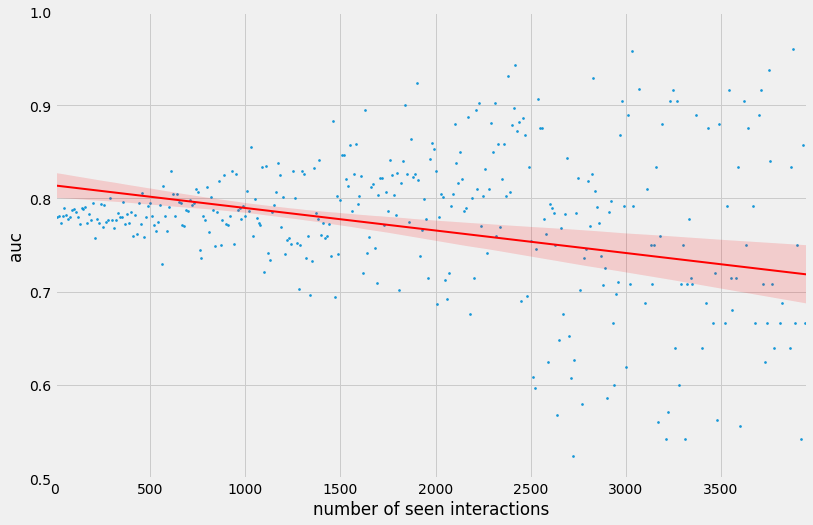

In [16]:
def roc_score_per_interaction(x):
    try:
        return roc_auc_score(x.answered_correctly.values, x.predictions.values)
    except ValueError:
        return np.nan

df["num_iteractions"] = (df.groupby("user_id").cumcount() // 10) * 10
interactions_auc = df.groupby("num_iteractions").apply(roc_score_per_interaction)
interactions_auc = interactions_auc[~interactions_auc.isna()].copy()

fig, ax = plt.subplots(figsize=(12, 8))
sns.regplot(
    y=interactions_auc.values,
    x=interactions_auc.index,
    line_kws={"color": "red", "linewidth": 2},
    scatter_kws={"s": 3},
)
ax.set_ylim(0.5, 1)
ax.set_xlim(0, interactions_auc.index.max())
ax.set_ylabel("auc")
ax.set_xlabel("number of seen interactions")
plt.show()

# Real test

In [25]:
class Iter_Valid(object):
    def __init__(self, df, max_user=1000):
        df = df.reset_index(drop=True)
        self.df = df
        self.user_answer = df["user_answer"].astype(str).values
        self.answered_correctly = df["answered_correctly"].astype(str).values
        df["prior_group_responses"] = "[]"
        df["prior_group_answers_correct"] = "[]"
        self.sample_df = df[df["content_type_id"] == 0][["row_id"]]
        self.sample_df["answered_correctly"] = 0
        self.len = len(df)
        self.user_id = df.user_id.values
        self.task_container_id = df.task_container_id.values
        self.content_type_id = df.content_type_id.values
        self.max_user = max_user
        self.current = 0
        self.pre_user_answer_list = []
        self.pre_answered_correctly_list = []

    def __iter__(self):
        return self

    def fix_df(self, user_answer_list, answered_correctly_list, pre_start):
        df = self.df[pre_start : self.current].copy()
        sample_df = self.sample_df[pre_start : self.current].copy()
        df.loc[pre_start, "prior_group_responses"] = (
            "[" + ",".join(self.pre_user_answer_list) + "]"
        )
        df.loc[pre_start, "prior_group_answers_correct"] = (
            "[" + ",".join(self.pre_answered_correctly_list) + "]"
        )
        self.pre_user_answer_list = user_answer_list
        self.pre_answered_correctly_list = answered_correctly_list
        return df, sample_df

    def __next__(self):
        added_user = set()
        pre_start = self.current
        pre_added_user = -1
        pre_task_container_id = -1

        user_answer_list = []
        answered_correctly_list = []
        while self.current < self.len:
            crr_user_id = self.user_id[self.current]
            crr_task_container_id = self.task_container_id[self.current]
            crr_content_type_id = self.content_type_id[self.current]
            if crr_content_type_id == 1:
                # no more than one task_container_id of "questions" from any single user
                # so we only care for content_type_id == 0 to break loop
                user_answer_list.append(self.user_answer[self.current])
                answered_correctly_list.append(self.answered_correctly[self.current])
                self.current += 1
                continue
            if crr_user_id in added_user and (
                (crr_user_id != pre_added_user)
                or (crr_task_container_id != pre_task_container_id)
            ):
                # known user(not prev user or differnt task container)
                return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
            if len(added_user) == self.max_user:
                if (
                    crr_user_id == pre_added_user
                    and crr_task_container_id == pre_task_container_id
                ):
                    user_answer_list.append(self.user_answer[self.current])
                    answered_correctly_list.append(
                        self.answered_correctly[self.current]
                    )
                    self.current += 1
                    continue
                else:
                    return self.fix_df(
                        user_answer_list, answered_correctly_list, pre_start
                    )
            added_user.add(crr_user_id)
            pre_added_user = crr_user_id
            pre_task_container_id = crr_task_container_id
            user_answer_list.append(self.user_answer[self.current])
            answered_correctly_list.append(self.answered_correctly[self.current])
            self.current += 1
        if pre_start < self.current:
            return self.fix_df(user_answer_list, answered_correctly_list, pre_start)
        else:
            raise StopIteration()

In [33]:
%%time
inference_dataset = InferenceRIIDDataset(hdf5_file="train_no_lec_feats.h5",)
iter_test = Iter_Valid(valid,max_user=1000)
predicted = []
def set_predict(df):
    predicted.append(df)

CPU times: user 2.21 s, sys: 96.8 ms, total: 2.3 s
Wall time: 2.3 s


In [28]:
inference_dataset = InferenceRIIDDataset(hdf5_file="train_no_lec_feats.h5",)
iter_test = Iter_Valid(valid,max_user=1000)
predicted = []
def set_predict(df):
    predicted.append(df)

pbar = tqdm(total=len(valid))
previous_test_df = None
for (current_test, current_prediction_df) in iter_test:
    if previous_test_df is not None:
        previous_test_df["answered_correctly"] = eval(current_test["prior_group_answers_correct"].iloc[0])
        previous_test_df[~previous_test_df.content_type_id].groupby(
            "user_id"
        ).answered_correctly.apply(inference_dataset.update_answered_correctly)
        

    # your feature extraction and model training code here
    current_test = preprocess_df(current_test)
    previous_test_df = current_test.copy()
    
    current_test = current_test[~current_test.content_type_id].copy()

    # add current to cache
    current_test[
        ["row_id", "user_id", "content_id", "timestamp", "answered_correctly", "prior_question_elapsed_time"]
    ].groupby("user_id").apply(
        lambda user_rows: inference_dataset.update_user_rows(user_rows)
    )
    
    # your prediction code here
    current_test = predict_for_df(current_test)
    set_predict(current_test.loc[:, ["row_id", "answered_correctly"]])
    pbar.update(len(current_test))

KeyboardInterrupt: 

In [29]:
#validation score
y_pred = pd.concat(predicted).answered_correctly
y_true = valid[valid.content_type_id == 0].answered_correctly[:len(y_pred)]

print('validation auc:',roc_auc_score(y_true, y_pred))

validation auc: 0.8077434878428923


In [38]:
y_true

10977      1
10978      1
10979      1
10980      1
10981      1
          ..
4292693    1
4292694    0
4292695    1
4292696    1
4292697    1
Name: answered_correctly, Length: 115947, dtype: int8

In [39]:
y_pred

0         0.635927
1         0.588397
2         0.581650
3         0.911703
4         0.737461
            ...   
118026    0.956787
118027    0.911273
118028    0.783240
118029    0.995036
118030    0.741667
Name: answered_correctly, Length: 115947, dtype: float64